<h1><div align="center">Deep Learning From Scratch</div></h1>
<h2><div align="center">Modular Network</div></h2>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -p numpy,matplotlib,pandas,seaborn

Tue Jul 02 2019 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
matplotlib 3.1.0
pandas 0.24.2
seaborn 0.9.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Load Dataset

In [3]:
X_train = np.load('input/X_train.npy')
X_test = np.load('input/X_test.npy')
y_train = np.load('input/y_train.npy')
y_test = np.load('input/y_test.npy')

Preprocessing

In [4]:
input_layer_size = X_train.shape[1]

X_train /= 255.
X_test /= 255.

## Initialize weights

We define the initializatino function as we'll have to call it more than once

In [5]:
def init_weights(L_in, L_out):
    epsilon = 0.12

    return 2*np.random.rand(L_out, L_in+1)*epsilon - epsilon

Set the layer sizes we'll be using

In [6]:
hidden_layer_size = 50
num_labels = 10

Initialize the weights. In this case we use a array of weight matrices so that we can easily add/remove layers

In [7]:
Thetas = []
Thetas.append(init_weights(input_layer_size, hidden_layer_size))
Thetas.append(init_weights(hidden_layer_size, num_labels))

## Utility functions

One-hot encoding to define the labels

In [8]:
def one_hot(K, pos):
    y0 = np.zeros(K)
    y0[pos] = 1

    return y0

Activation function base class. Here we must provide an interface to both the activation function and its derivative

In [9]:
class Activation(object):
    def f(z):
        pass

    def df(z):
        pass

The various activation functions simply extend the base class

In [10]:
class Linear(Activation):
    def f(z):
        return z

    def df(z):
        return np.ones(z.shape)

class ReLu(Activation):
    def f(z):
        return np.where(z > 0, z, 0)

    def df(z):
        return np.where(z > 0, 1, 0)

class Sigmoid(Activation):
    def f(z):
        return 1./(1+np.exp(-z))
    
    def df(z):
        h = Sigmoid.f(z)
        return h*(1-h)

class TanH(Activation):
    def f(z):
        return np.tanh(z)

    def df(z):
        return 1-np.power(np.tanh(z), 2.0)

## Forward Propagation and Prediction

The forward and predict functions are also generalized

In [11]:
def forward(Theta, X, active):
    N = X.shape[0]

    # Add the bias column
    X_ = np.concatenate((np.ones((N, 1)), X), 1)

    # Multiply by the weights
    z = np.dot(X_, Theta.T)

    # Apply the activation function
    a = active.f(z)

    return a

The predict function now takes the entire model as input and it must loop over the various layers

In [12]:
def predict(model, X):
    h = X.copy()

    for i in range(0, len(model), 2):
        theta = model[i]
        activation = model[i+1]

        h = forward(theta, h, activation)

    return np.argmax(h, 1)

The accuracy function is just the same as before

In [13]:
def accuracy(y_, y):
    return np.mean((y_ == y.flatten()))*100.

## Back propagation

In [14]:
def backprop(model, X, y):
    M = X.shape[0]

    Thetas=[0]
    Thetas.extend(model[0::2])
    activations = [0]
    activations.extend(model[1::2])

    layers = len(Thetas)

    K = Thetas[-1].shape[0]
    J = 0

    Deltas = [0]

    for i in range(1, layers):
        Deltas.append(np.zeros(Thetas[i].shape))

    deltas = [0]*(layers+1)

    for i in range(M):
        As = [0]
        Zs = [0, 0]
        Hs = [0, X[i]]

        # Forward propagation, saving intermediate results
        As.append(np.concatenate(([1], Hs[1])))  # Input layer

        for l in range(2, layers+1):
            Zs.append(np.dot(Thetas[l-1], As[l-1]))
            Hs.append(activations[l-1].f(Zs[l]))
            As.append(np.concatenate(([1], Hs[l])))

        y0 = one_hot(K, y[i])

        # Cross entropy
        J -= np.dot(y0.T, np.log(Hs[-1]))+np.dot((1-y0).T, np.log(1-Hs[-1]))

        deltas[layers] = Hs[layers]-y0

        # Calculate the weight deltas
        for l in range(layers-1, 1, -1):
            deltas[l] = np.dot(Thetas[l].T, deltas[l+1])[1:]*activations[l].df(Zs[l])

        Deltas[2] += np.outer(deltas[3], As[2])
        Deltas[1] += np.outer(deltas[2], As[1])

    J /= M

    grads = []

    grads.append(Deltas[1]/M)
    grads.append(Deltas[2]/M)

    return [J, grads]

## Model Definition

In [16]:
model = []

model.append(Thetas[0])
model.append(Sigmoid)
model.append(Thetas[1])
model.append(Sigmoid)

## Training procedure
The same basic idea as before

In [18]:
step = 0
tol = 1e-3
J_old = 1/tol
diff = 1

acc_train = []
acc_test = []
J_val = []
steps = []

while diff > tol:
    J_train, grads = backprop(model, X_train, y_train)

    diff = abs(J_old-J_train)
    J_old = J_train
    J_val.append(J_train)

    step += 1

    if step % 10 == 0:
        pred_train = predict(model, X_train)
        pred_test = predict(model, X_test)

        J_test, grads = backprop(model, X_test, y_test)

        acc_train.append(accuracy(pred_train, y_train))
        acc_test.append(accuracy(pred_test, y_test))
        steps.append(step)
        
        print(step, J_train, J_test, acc_train[-1], acc_test[-1])

    for i in range(len(Thetas)):
        Thetas[i] -= .5*grads[i]

10 2.096568690000466 2.1798992218526867 70.96000000000001 67.0
20 1.874444383369703 1.9629095976129367 74.78 71.7
30 1.7029552832726302 1.7946663901195175 77.52 74.3
40 1.5655809054498848 1.6597549727737826 79.82000000000001 76.7
50 1.4521858999140604 1.5484729847142544 82.06 78.10000000000001
60 1.3567568955227334 1.4550002948421332 83.44 79.2
70 1.275303503674023 1.3754336851065578 84.44 80.60000000000001
80 1.2049324829641062 1.306908957530184 85.64 81.6
90 1.1434795391618744 1.247258979398019 86.3 83.39999999999999
100 1.0893167211232442 1.1948382101298853 87.14 84.1
110 1.041213464633608 1.1483955459512958 87.86 85.0
120 0.9982281667088452 1.106972885588144 88.24 85.7
130 0.9596263691711306 1.0698258831867822 88.74 85.9
140 0.9248212219604975 1.0363639317843367 89.03999999999999 86.1
150 0.8933313361675855 1.00610620999164 89.32 86.4
160 0.8647518576048602 0.9786509157874744 89.78 86.6


## Accuracy during training

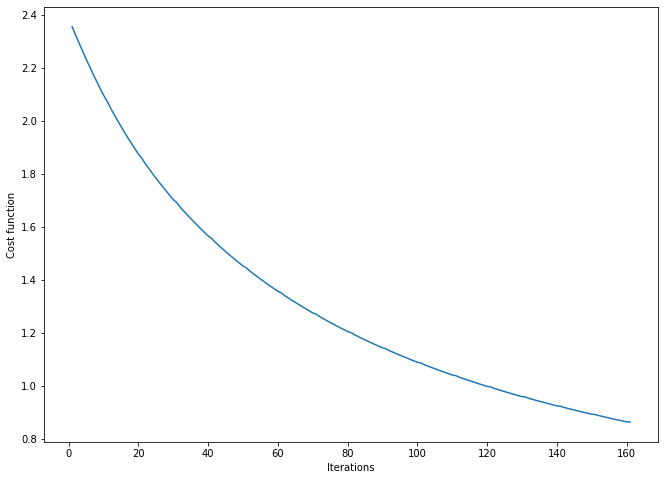

In [19]:
plt.plot(np.arange(1, len(J_val)+1), J_val)
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.gcf().set_size_inches(11, 8)

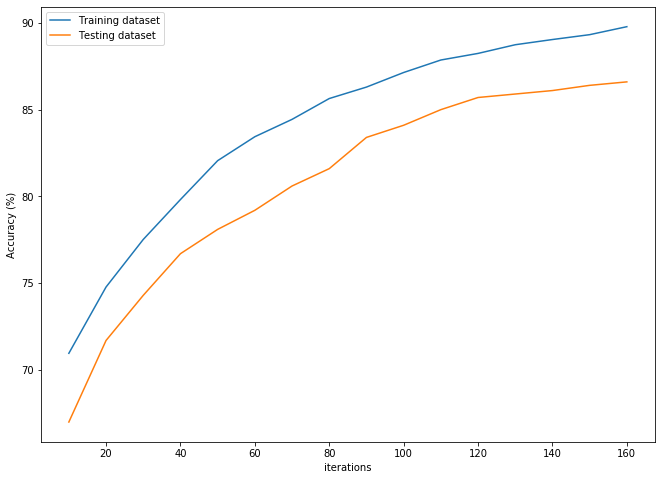

In [20]:
plt.plot(steps, acc_train, label='Training dataset')
plt.plot(steps, acc_test, label='Testing dataset')
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.gcf().set_size_inches(11, 8)